In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [2]:
df = pd.read_csv('weatherHistory.csv', nrows=2000)
df.columns

Index(['Formatted Date', 'Summary', 'Precip Type', 'Temperature (C)',
       'Apparent Temperature (C)', 'Humidity', 'Wind Speed (km/h)',
       'Wind Bearing (degrees)', 'Visibility (km)', 'Loud Cover',
       'Pressure (millibars)', 'Daily Summary'],
      dtype='object')

<Axes: >

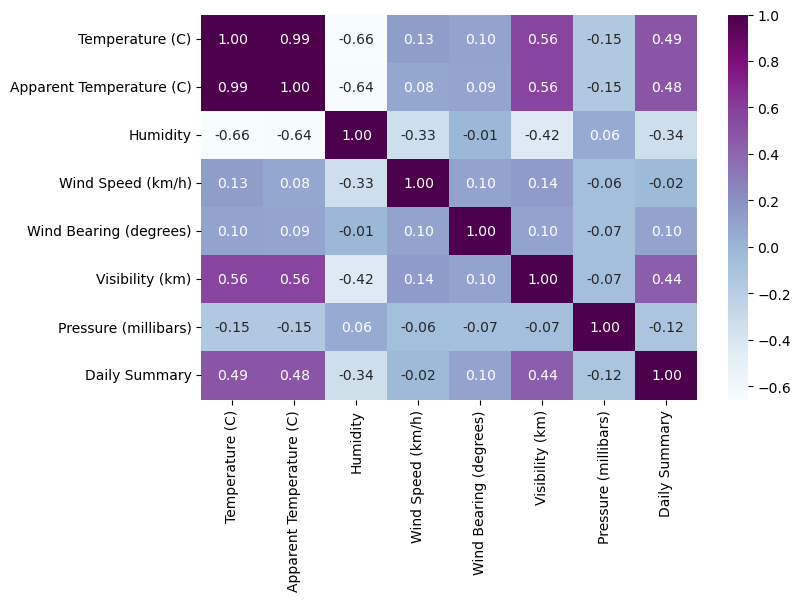

In [3]:
df = df.drop(['Formatted Date', 'Summary', 'Precip Type', 'Loud Cover'], axis=1)
df.fillna(df.mean(numeric_only=True), inplace=True)
df.fillna(df.mode().iloc[0], inplace=True)

label_enc = LabelEncoder()
ordinal_columns = df.select_dtypes('object').columns
for column in ordinal_columns:
    df[column] = label_enc.fit_transform(df[column])

    
normalized_values = StandardScaler().fit_transform(df)
df = pd.DataFrame(normalized_values, columns=df.columns)
 
corr_matrix = df.corr()
plt.figure(figsize=(8,5))
sns.heatmap(corr_matrix, annot=True, cmap="BuPu", fmt=".2f")

In [4]:
Y = df['Apparent Temperature (C)'].values
X = df.loc[:, df.columns != 'Apparent Temperature (C)'].values

X_single = pd.DataFrame(df['Humidity'])

X_train, X_test, single_train, single_test, Y_train, Y_test = train_test_split(X, X_single, Y, test_size = 0.3, random_state = 42)

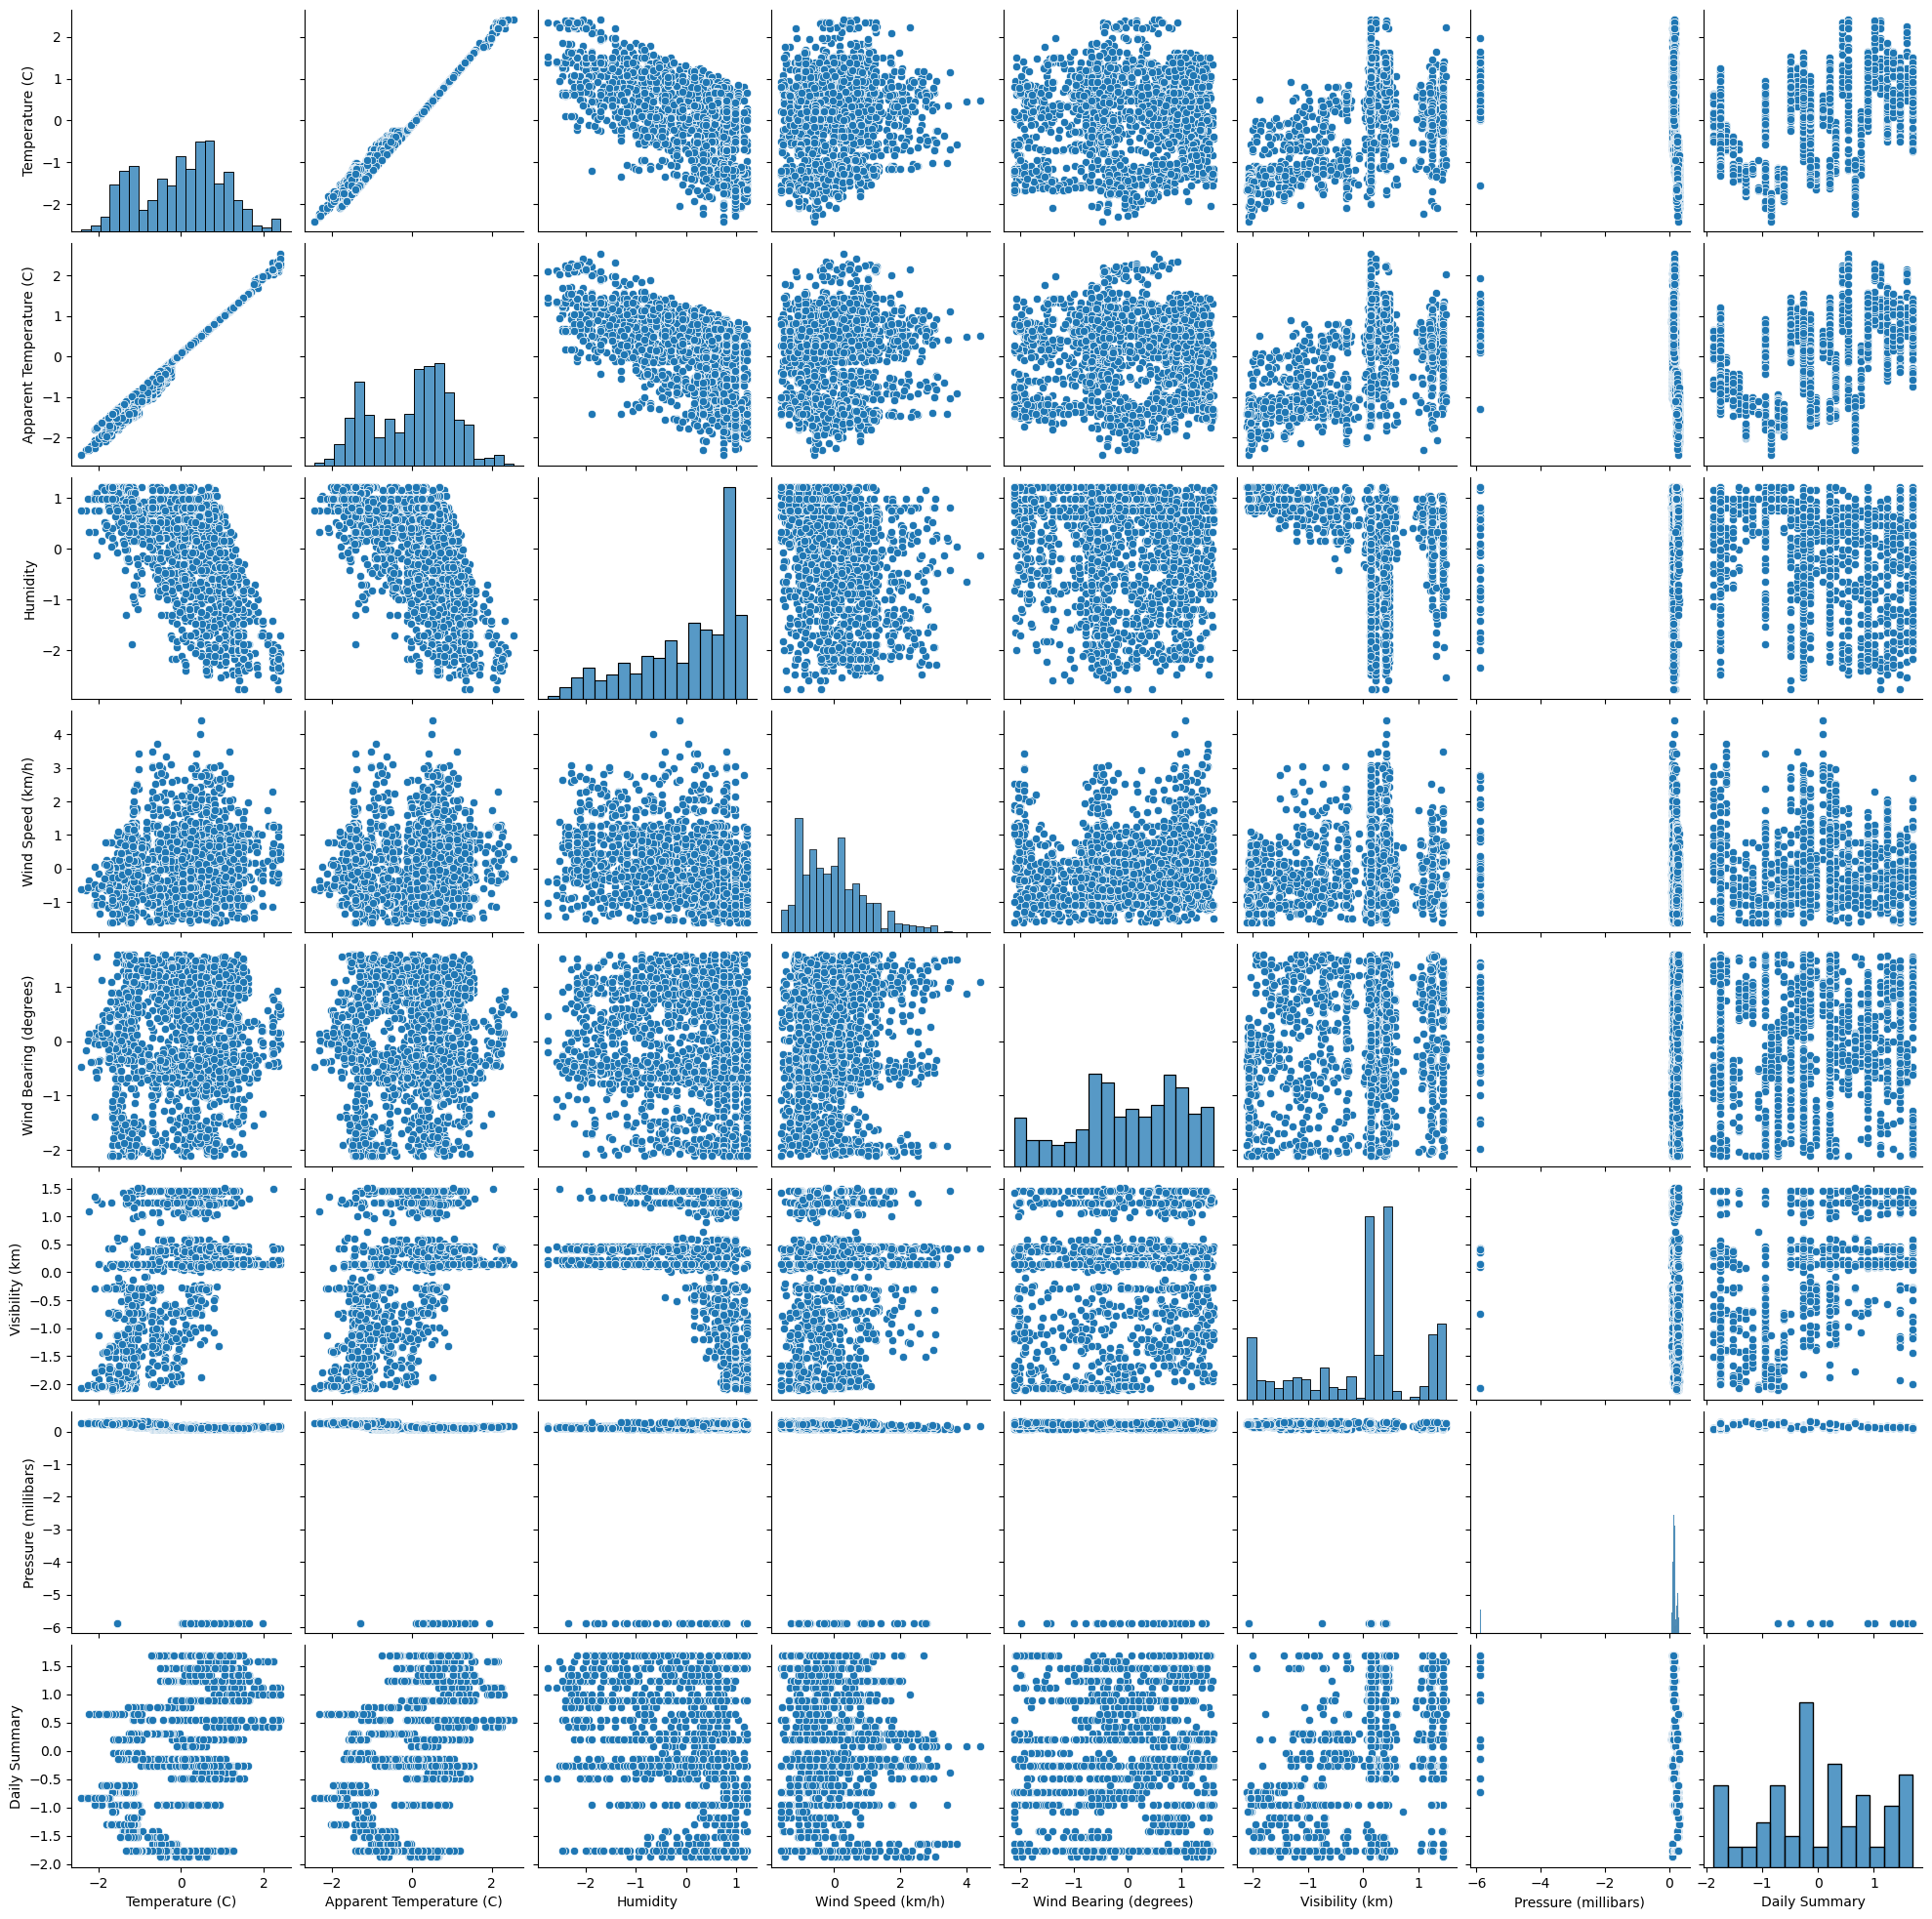

In [5]:
sns.pairplot(df, vars=['Temperature (C)', 'Apparent Temperature (C)', 'Humidity', 'Wind Speed (km/h)',
                     'Wind Bearing (degrees)', 'Visibility (km)', 'Pressure (millibars)', 'Daily Summary'])

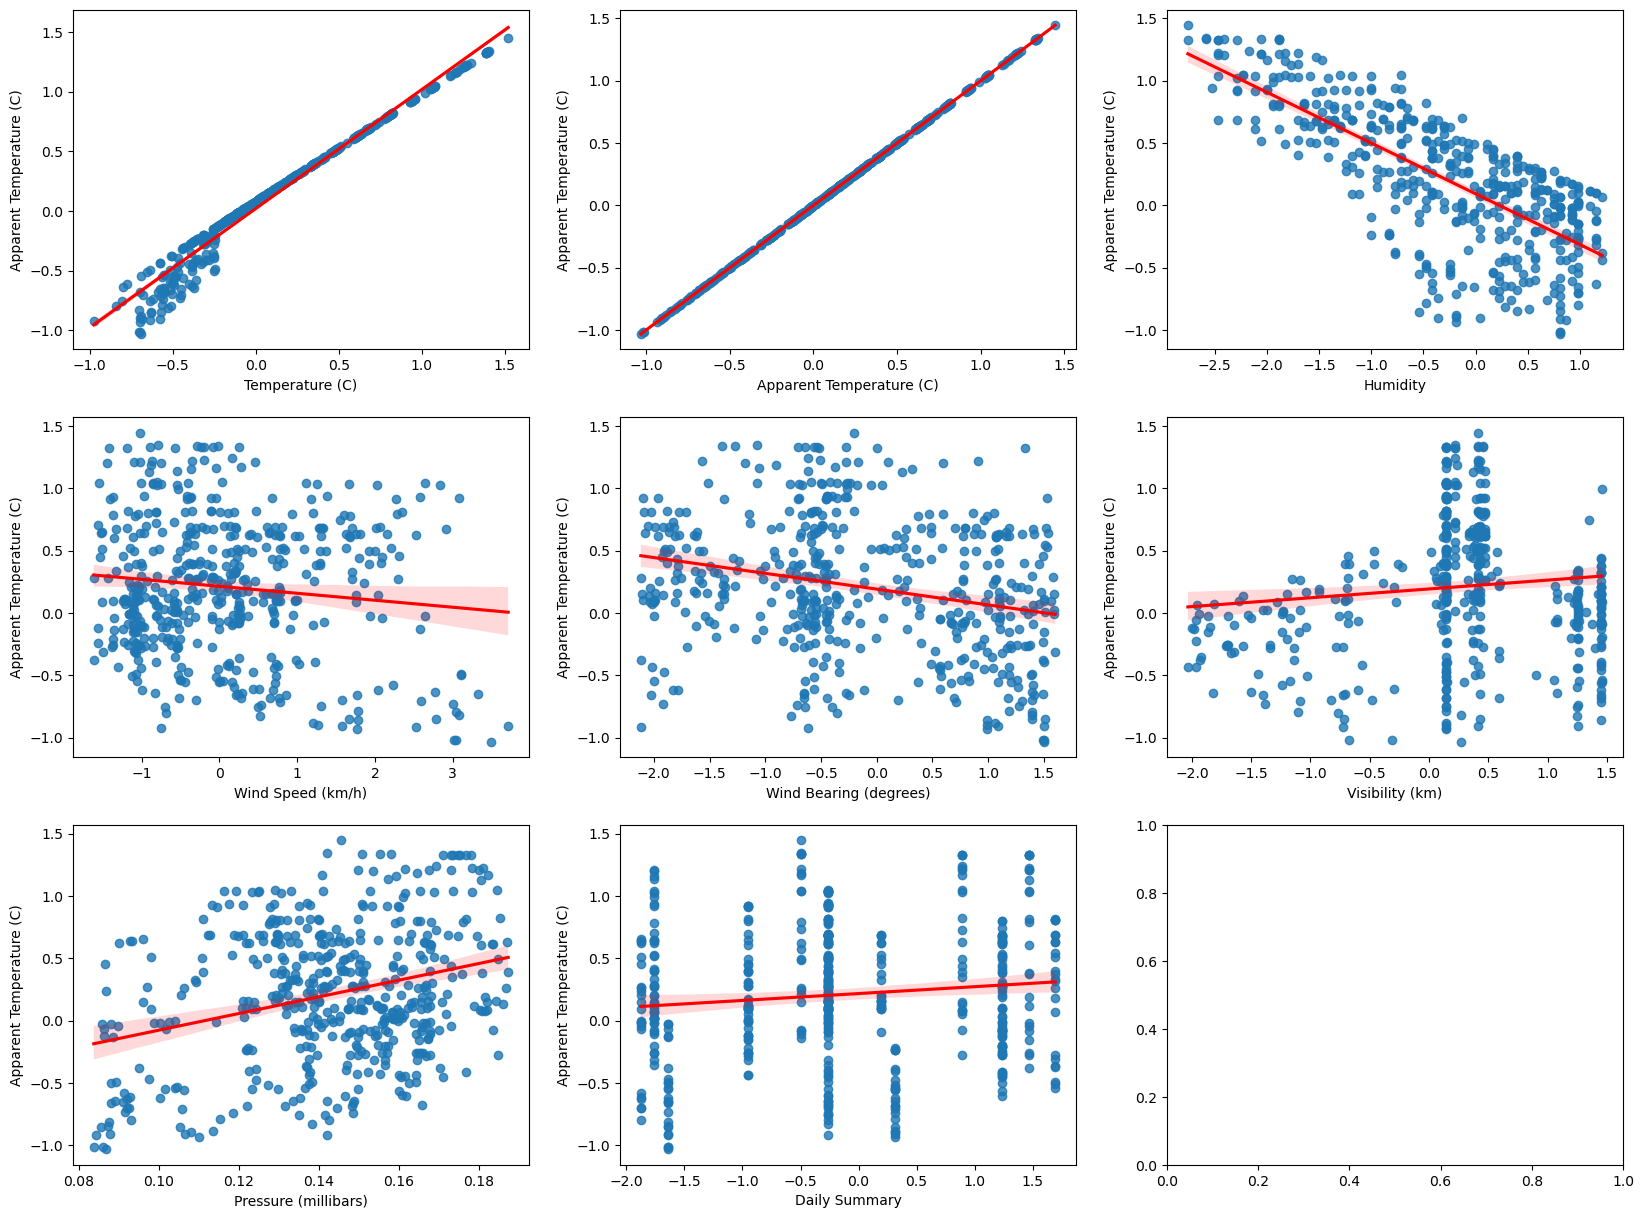

In [6]:
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(20, 15))
for ax, column in zip(axs.ravel(), df.columns): 
    sns.regplot(x=column, y="Apparent Temperature (C)", data=df[0:500], line_kws=dict(color="r"), ax=ax)
plt.show()

In [7]:
singleX_lasso = Lasso(alpha=0.3)
singleX_lasso.fit(single_train, Y_train)
singleX_lasso_predict = singleX_lasso.predict(single_test)

lasso = Lasso(alpha=0.3)
lasso.fit(X_train, Y_train)
lasso_predict = lasso.predict(X_test)

In [8]:
#Теж саме що й метод LinearRegression з sklearn (видають однакові результати)
singleX_ridge = Ridge()
singleX_ridge.fit(single_train, Y_train)
singleX_ridge_predict = singleX_ridge.predict(single_test)

ridge = Ridge()
ridge.fit(X_train, Y_train)
ridge_predict = ridge.predict(X_test)

In [9]:
scores = pd.DataFrame()
scores['Model'] = ['Lasso for single X', 'Lasso for multiple X', 'Ridge for single X', 'Ridge for multiple X']
scores['R2 pre-tuning'] = [singleX_lasso.score(single_test, Y_test), lasso.score(X_test, Y_test), singleX_ridge.score(single_test, Y_test), ridge.score(X_test, Y_test)]
scores['MAE pre-tuning'] = [mean_absolute_error(Y_test, singleX_lasso_predict), mean_absolute_error(Y_test, lasso_predict), 
                   mean_absolute_error(Y_test, singleX_ridge_predict), mean_absolute_error(Y_test, ridge_predict)]
scores['MSE pre-tuning'] = [mean_squared_error(Y_test, singleX_lasso_predict), mean_squared_error(Y_test, lasso_predict), 
                   mean_squared_error(Y_test, singleX_ridge_predict), mean_squared_error(Y_test, ridge_predict)]

In [10]:
alphas = np.logspace(-10, 10, 21)

singleX_ridge_scores = []
ridge_scores = []
singleX_lasso_scores = []
lasso_scores = []

for alpha in alphas:
    
    singleX_ridge_score = -cross_val_score(Ridge(alpha=alpha), single_train, Y_train, cv=5, scoring='neg_mean_squared_error')
    ridge_score = -cross_val_score(Ridge(alpha=alpha), X_train, Y_train, cv=5, scoring='neg_mean_squared_error')

    singleX_lasso_score = -cross_val_score(Lasso(alpha=alpha), single_train, Y_train, cv=5, scoring='neg_mean_squared_error')
    lasso_score = -cross_val_score(Lasso(alpha=alpha), X_train, Y_train, cv=5, scoring='neg_mean_squared_error')
    
    singleX_ridge_scores.append(np.mean(singleX_ridge_score))
    ridge_scores.append(np.mean(ridge_score))

    singleX_lasso_scores.append(np.mean(singleX_lasso_score))
    lasso_scores.append(np.mean(lasso_score))

best_alpha_singleX_ridge = alphas[np.argmin(singleX_ridge_scores)]
best_alpha_ridge = alphas[np.argmin(ridge_scores)]

best_alpha_singleX_lasso = alphas[np.argmin(singleX_lasso_scores)]
best_alpha_lasso = alphas[np.argmin(lasso_scores)]

print("Best Alpha for Ridge with single X: ", best_alpha_singleX_ridge)
print("Best Alpha for Lasso with single X: ", best_alpha_singleX_lasso)
print("Best Alpha for Ridge: ", best_alpha_ridge)
print("Best Alpha for Lasso: ", best_alpha_lasso)

Best Alpha for Ridge with single X:  1.0
Best Alpha for Lasso with single X:  0.001
Best Alpha for Ridge:  1e-10
Best Alpha for Lasso:  0.0001


In [11]:
singleX_lasso.set_params(alpha=best_alpha_singleX_lasso).fit(single_train, Y_train)
opt_singleX_lasso_predict = singleX_lasso.predict(single_test)

lasso.set_params(alpha=best_alpha_lasso).fit(X_train, Y_train)
opt_lasso_predict = lasso.predict(X_test)

singleX_ridge.set_params(alpha=best_alpha_singleX_ridge).fit(single_train, Y_train)
opt_singleX_ridge_predict = singleX_ridge.predict(single_test)

ridge.set_params(alpha=best_alpha_ridge).fit(X_train, Y_train)
opt_ridge_predict = ridge.predict(X_test)

scores['R2 post-tuning'] = [singleX_lasso.score(single_test, Y_test), lasso.score(X_test, Y_test), singleX_ridge.score(single_test, Y_test), ridge.score(X_test, Y_test)]
scores['MAE post-tuning'] = [mean_absolute_error(Y_test, opt_singleX_lasso_predict), mean_absolute_error(Y_test, opt_lasso_predict), 
                   mean_absolute_error(Y_test, opt_singleX_ridge_predict), mean_absolute_error(Y_test, opt_ridge_predict)]
scores['MSE post-tuning'] = [mean_squared_error(Y_test, opt_singleX_lasso_predict), mean_squared_error(Y_test, opt_lasso_predict), 
                   mean_squared_error(Y_test, opt_singleX_ridge_predict), mean_squared_error(Y_test, opt_ridge_predict)]

scores  


,Model,R2 pre-tuning,MAE pre-tuning,MSE pre-tuning,R2 post-tuning,MAE post-tuning,MSE post-tuning
0,Lasso for single X,0.312779,0.712052,0.697191,0.400838,0.664880,0.607855
1,Lasso for multiple X,0.894767,0.273761,0.106760,0.991788,0.073285,0.008331
2,Ridge for single X,0.400832,0.664856,0.607861,0.400832,0.664856,0.607861
3,Ridge for multiple X,0.991773,0.073406,0.008346,0.991791,0.073295,0.008328


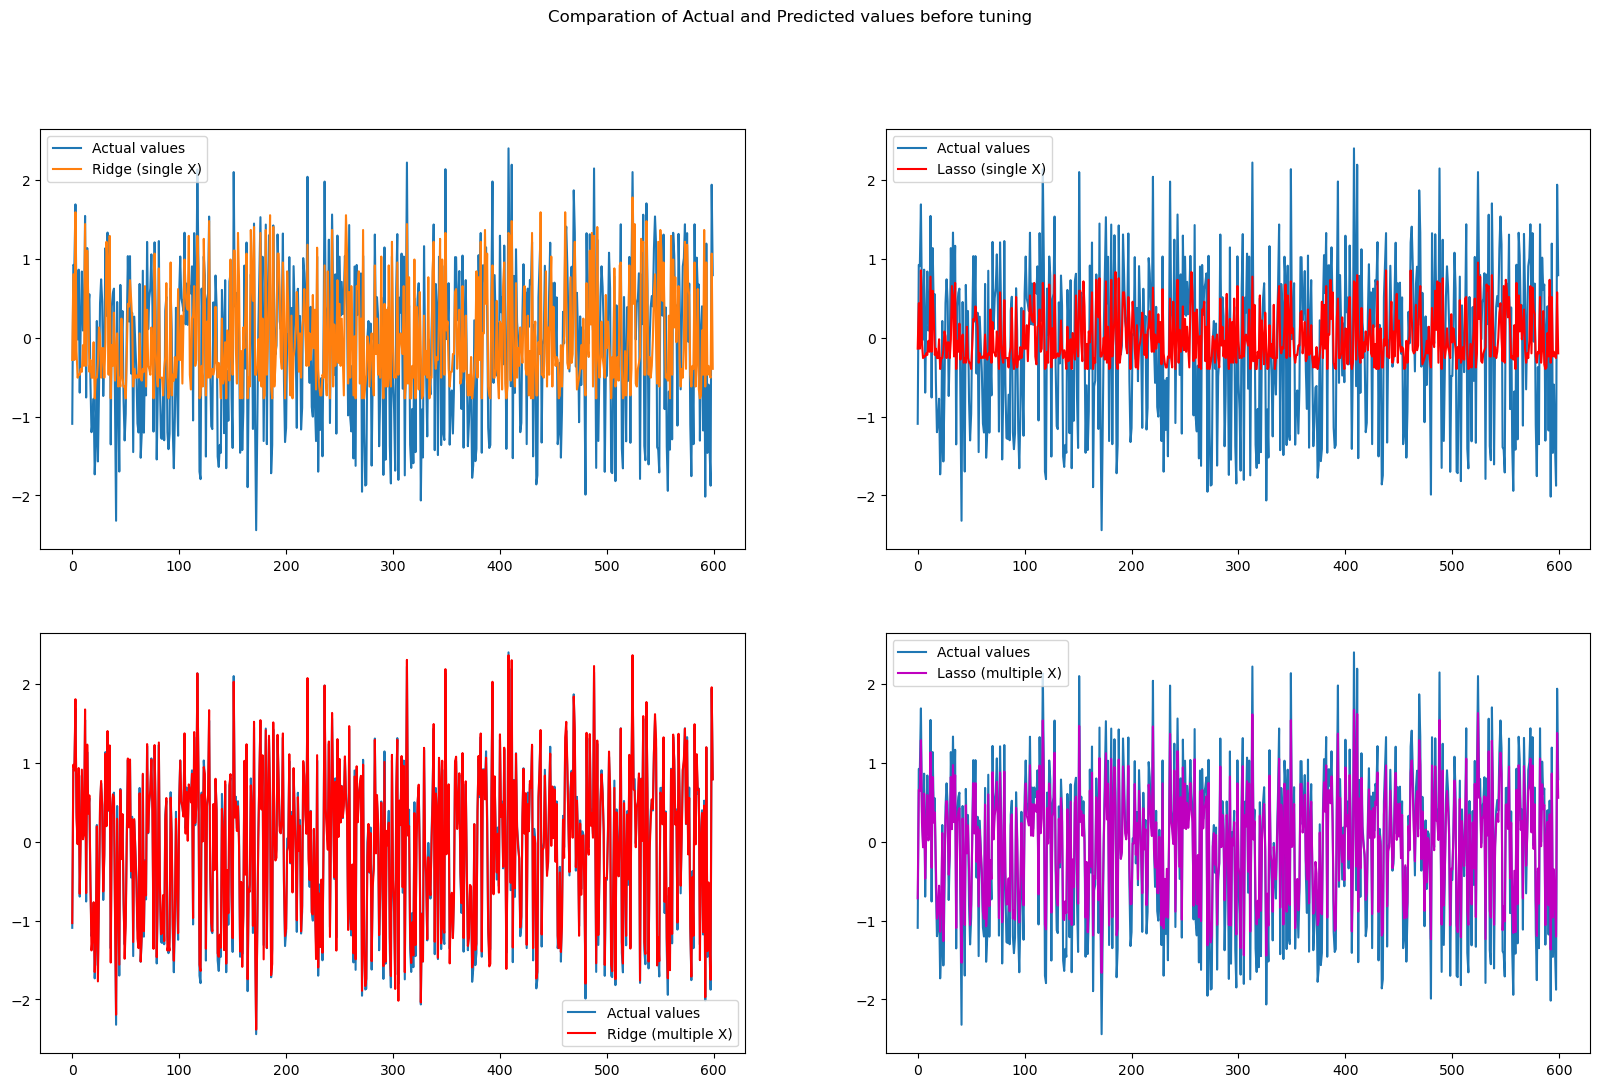

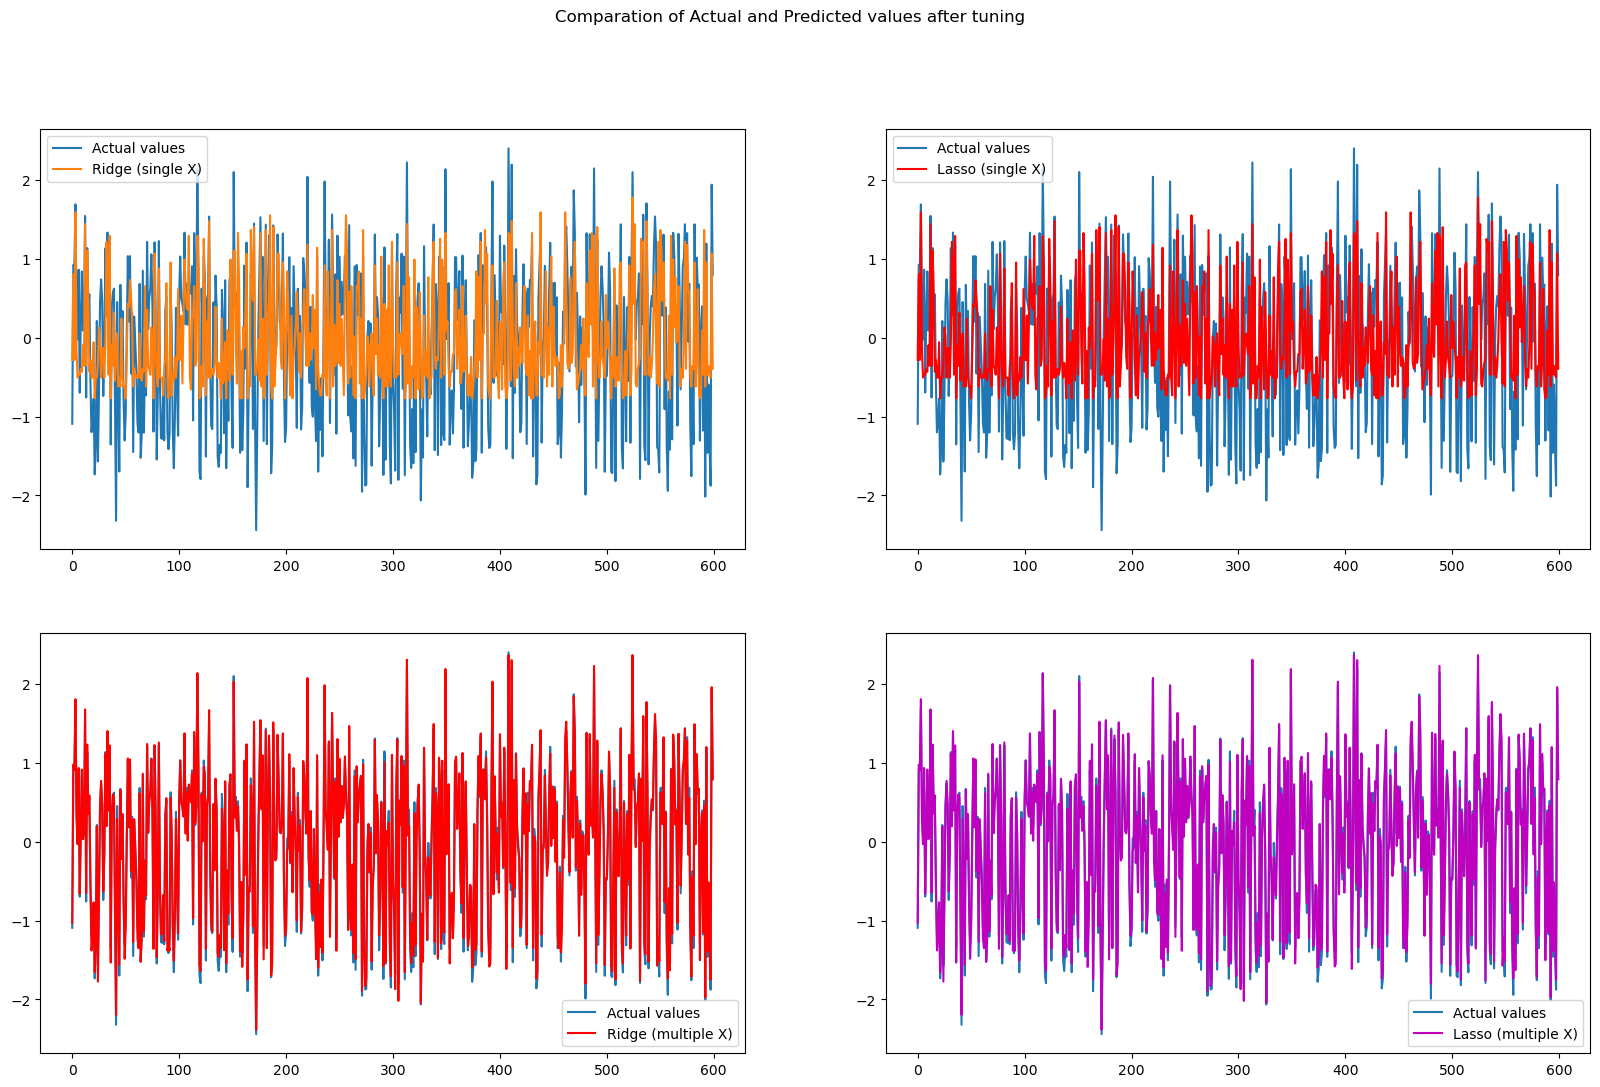

In [13]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(20, 12))
fig.suptitle('Comparation of Actual and Predicted values before tuning')

ax1.plot([i for i in range(len(Y_test))], Y_test, label="Actual values")
ax1.plot([i for i in range(len(Y_test))], singleX_ridge_predict, label="Ridge (single X)")
ax1.legend()

ax2.plot([i for i in range(len(Y_test))], Y_test, label="Actual values")
ax2.plot([i for i in range(len(Y_test))], singleX_lasso_predict, c='r', label="Lasso (single X)")
ax2.legend()

ax3.plot([i for i in range(len(Y_test))], Y_test, label="Actual values")
ax3.plot([i for i in range(len(Y_test))], ridge_predict, c='r', label="Ridge (multiple X)")
ax3.legend()

ax4.plot([i for i in range(len(Y_test))], Y_test, label="Actual values")
ax4.plot([i for i in range(len(Y_test))], lasso_predict, c='m', label="Lasso (multiple X)")
ax4.legend()

plt.show()


fig, [[ax1, ax2],[ax3, ax4]] = plt.subplots(2, 2, figsize=(20, 12))
fig.suptitle('Comparation of Actual and Predicted values after tuning')

ax1.plot([i for i in range(len(Y_test))], Y_test, label="Actual values")
ax1.plot([i for i in range(len(Y_test))], opt_singleX_ridge_predict, label="Ridge (single X)")
ax1.legend()

ax2.plot([i for i in range(len(Y_test))], Y_test, label="Actual values")
ax2.plot([i for i in range(len(Y_test))], opt_singleX_lasso_predict, c='r', label="Lasso (single X)")
ax2.legend()

ax3.plot([i for i in range(len(Y_test))], Y_test, label="Actual values")
ax3.plot([i for i in range(len(Y_test))], opt_ridge_predict, c='r', label="Ridge (multiple X)")
ax3.legend()

ax4.plot([i for i in range(len(Y_test))], Y_test, label="Actual values")
ax4.plot([i for i in range(len(Y_test))], opt_lasso_predict, c='m', label="Lasso (multiple X)")
ax4.legend()

plt.show()